In [36]:
import pandas as pd
import sys
sys.path.append("..")
from src.Utils import get_ents_spans

data = pd.read_parquet("../data/dataset/shs100k2/data.parquet").reset_index()


# Overview

In [37]:
data_spans = pd.DataFrame(pd.json_normalize(data.IOB.apply(get_ents_spans)))
data["WoA"] = data_spans.WoA
data.WoA = data.WoA.apply(lambda x: x if x == x else [])
data["Artist"] = data_spans.Artist
data.Artist = data.Artist.apply(lambda x: x if x == x else [])

data["WoA_count"] = data.WoA.apply(len)
data["Artist_count"] = data.Artist.apply(len)
data["WoA_missing"] = data.WoA_count == 0
data["Artist_missing"] = data.Artist_count == 0
data["WoA_first"] = data.WoA.apply(lambda x: x[0] if len(x) > 0 else None)
data["Artist_first"] = data.Artist.apply(lambda x: x[0] if len(x) > 0 else None)
data["WoA_len"] = data.WoA_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["Artist_len"] = data.Artist_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["WoA_start"] = data.WoA_first.apply(lambda x: x[0] if x else None)
data["Artist_start"] = data.Artist_first.apply(lambda x: x[0] if x else None)


In [38]:
data[
    ["split", "set_id", "yt_id", "WoA_count", "Artist_count", 
     "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
     "WoA_start", "Artist_start"]
    ].groupby("split").agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "max"], "Artist_count": ["min", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["median", "max"], "Artist_len": ["median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


set_id  yt_id WoA_count     Artist_count     WoA_missing  \
      nunique  count       min max          min max         sum   
split                                                             
TEST     1655   7755         0   3            0   6           7   
TRAIN    5304  62486         0   4            0   5           4   
VAL      1811   7924         0   3            0   4           6   

      Artist_missing WoA_len       Artist_len       WoA_start Artist_start  
                 sum  median   max     median   max    median       median  
split                                                                       
TEST              28     3.0  15.0        2.0  10.0       3.0          0.0  
TRAIN             31     3.0  19.0        2.0   9.0       3.0          0.0  
VAL               21     3.0  16.0        2.0   8.0       3.0          0.0

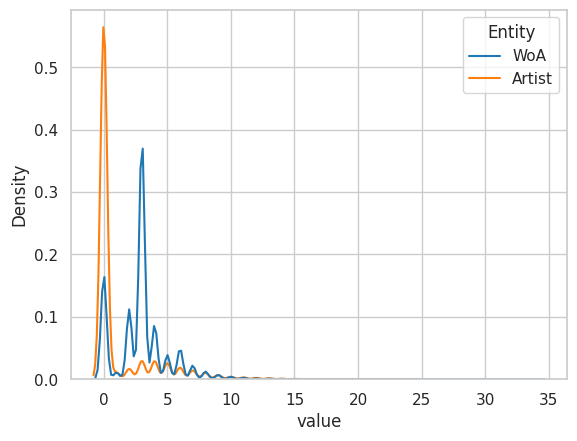

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("notebook")  # Increases font sizes for presentations
sns.kdeplot(
    pd.melt(
        data[["yt_id", "WoA_start", "Artist_start"]].rename(columns={"WoA_start": "WoA", "Artist_start": "Artist"}),
        var_name="Entity", id_vars="yt_id", value_vars=["WoA", "Artist"]),
    hue="Entity",
    x="value"
)
plt.savefig("../figures/kde_startindex.pdf")
plt.show()


# Automatic vs. Human Annotations

In [40]:
data.dropna(subset="IOB_annotated")


,index,set_id,ver_id,yt_id,title,performer,has_file,has_cqt_ch,has_cqt_20,has_crema,...,WoA_count,Artist_count,WoA_missing,Artist_missing,WoA_first,Artist_first,WoA_len,Artist_len,WoA_start,Artist_start
63,130,21,84,4SE8UvqaSWQ,[End (Medley: A) If I Fell B) Michelle C) Yest...,"[dr. fink, the mystery band, mystery band]",True,True,True,True,...,0,2,True,False,None,"(2, 3)",NaN,2.0,NaN,2.0
160,354,58,58,Ajp0Uaw4rqo,"[(I Can't Help) Falling in Love With You, Fall...",[ub40],True,True,True,True,...,1,1,False,False,"(1, 5)","(0, 0)",5.0,1.0,1.0,0.0
185,410,58,88,-cbPbDQhoyg,[I Can't Help Falling in Love],[enrico ruggeri],True,True,True,True,...,1,1,False,False,"(0, 5)","(7, 8)",6.0,2.0,0.0,7.0
330,740,96,19,g2BFp_F4PAQ,[My Favorite Things],"[petra magoni, ferruccio spinetti, nico gori]",True,True,True,True,...,1,1,False,False,"(3, 5)","(0, 1)",3.0,2.0,3.0,0.0
340,766,96,33,1s_5oZqqVQk,[My Favorite Things],"[percy faith, orchestra]",True,True,True,True,...,1,0,False,True,"(0, 2)",None,3.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73299,168342,4991,5,sblZP1MmvGI,[Voulez-vous],[morgana lefay],True,None,None,None,...,1,0,False,True,"(7, 7)",None,1.0,NaN,7.0,NaN
73713,169272,5061,1,OWiXyAAw1Ek,[Don't Cry out Loud],[melissa manchester],True,None,None,None,...,1,1,False,False,"(4, 7)","(9, 10)",4.0,2.0,4.0,9.0
75658,173708,5451,1,fHTnv8YdZsA,[You Can't Sit Down],"[doug fowlkes, the airdales, airdales]",False,None,None,None,...,1,0,False,True,"(0, 3)",None,4.0,NaN,0.0,NaN
75670,173734,5453,4,fCx0KpZaXOY,[Grenade],[megan nicole],True,None,None,None,...,1,2,False,False,"(0, 0)","(2, 3)",1.0,2.0,0.0,2.0


In [28]:
import pandas as pd

data = pd.read_parquet("../data/intermediate/shs100k2_IOB_annotated.parquet").dropna(subset="IOB").dropna(
    subset="IOB_annotated"
)


In [30]:
data.Attr


130       video_title
131       description
354       video_title
355       description
410       video_title
             ...     
173709    description
173734    video_title
173735    description
174724    video_title
174725    description
Name: Attr, Length: 614, dtype: object